1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


C:\Users\marcb\anaconda3\envs\greystone\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


TensorFlow RMSE: 1.5124679338430265


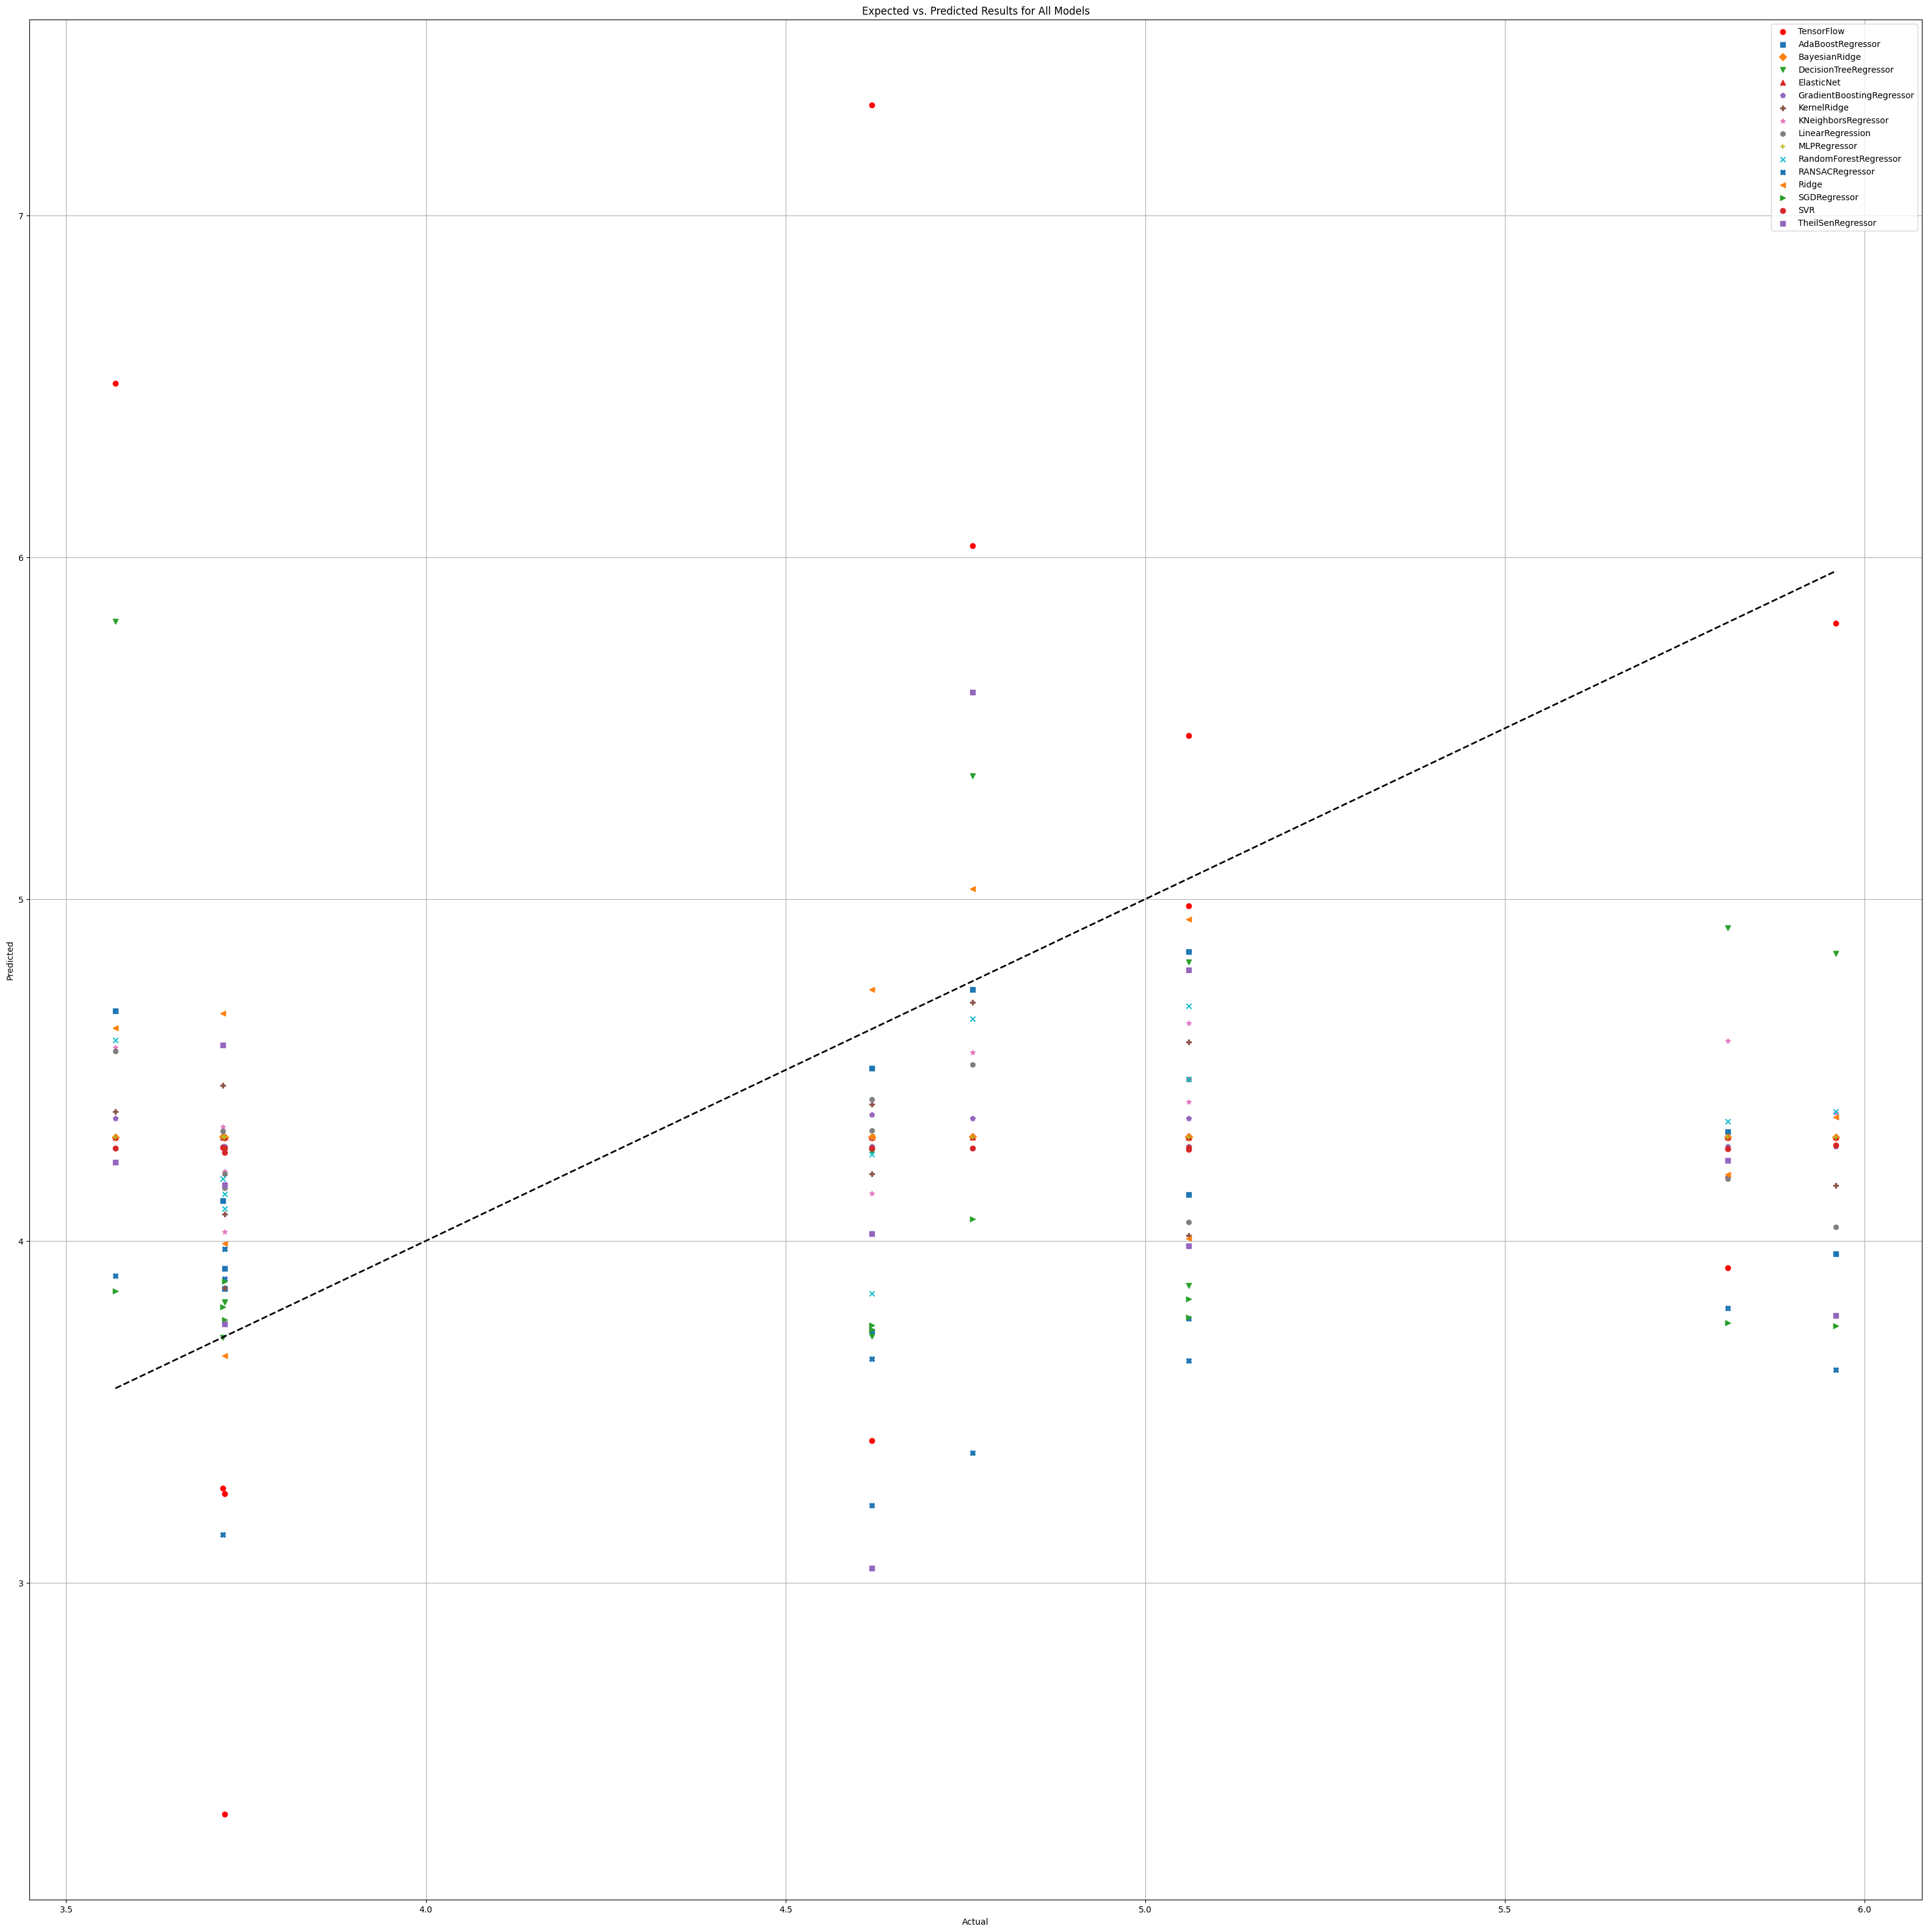

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import joblib

# Load the data
file_path = "data_nr_benefit_filtered.xlsx"
data = pd.read_excel(file_path)

# Define columns
data_columns = [
    'Wetland Type - Provincial Class',
    'Wetland Type - Federal Class',
    'Water Regime Indicator',
    'Specific Vegetation Type',
    '% Vegetation Cover for Specific Vegetation Cover Types',
    '% High Woody Canopy Cover (>5m)',
    'Phragmites present (Y/N)',
    'Soil Type',
    '% of Surface Water Present',
    'Depth of Saturation (cm)',
    'Average Depth of Living Moss (cm)',
    'Average Total Depth of Organics',
    'Average Organic Depth (cm)',
    'Hydrogeomorphic Class',
    '% Moss Cover'
]

results_columns = ['NR_Benefit']

# Prepare data for regression
X = data[data_columns]
y = data[results_columns[0]]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load trained models and their weights
model_directory = "NR_benefit_filtered"

best_models = {}

# Load TensorFlow model
tensorflow_model_filename = './NR_benefit_filtered/TensorFlow_model.h5'
model_tf = tf.keras.models.load_model(tensorflow_model_filename)
scaler_tf = joblib.load("./NR_benefit_filtered/scaler_tf.pkl")

# Standardize the test data for TensorFlow model
X_test_scaled_tf = scaler_tf.transform(X_test)

# Evaluate the TensorFlow model
y_pred_tf = model_tf.predict(X_test_scaled_tf)
rmse_tf = mean_squared_error(y_test, y_pred_tf, squared=False)
print(f"TensorFlow RMSE: {rmse_tf}")

# Add TensorFlow model to best_models
best_models['TensorFlow'] = (model_tf, y_pred_tf)

# Load other models
sklearn_model_filenames = [filename for filename in os.listdir(model_directory) if filename.endswith("_model.pkl")]

# Define markers for different models
markers = ['o', 's', 'D', 'v', '^', 'p', 'P', '*', 'h', '+', 'x', 'X', '<', '>']

for idx, filename in enumerate(sklearn_model_filenames):
    model_name = filename.split("_")[0]
    model = joblib.load(os.path.join(model_directory, filename))
    y_pred = model.predict(X_test)
    best_models[model_name] = (model, y_pred)

# Plot expected vs. predicted results for all models on the same graph
plt.figure(figsize=(40, 40))

# Plot predictions for TensorFlow model
plt.scatter(y_test, y_pred_tf, color='red', label='TensorFlow', marker='o')

# Plot predictions for other models
for idx, (model_name, (model, y_pred)) in enumerate(best_models.items()):
    if model_name != 'TensorFlow':
        marker = markers[idx % len(markers)]  # Cycle through markers
        plt.scatter(y_test, y_pred, label=model_name, marker=marker)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Expected vs. Predicted Results for All Models')
plt.legend()
plt.grid(True)

output_filename = "./model_plots/all_models_predictions_plot.png"
plt.savefig(output_filename)
plt.show()
